In [2]:
# Import the data_cleaning module (make sure this file is in the same directory or on the PYTHONPATH)
import data_cleaning

# Data Cleaning:
chunk_size = 100_000

restaurants_df = data_cleaning.filter_business_data("data/yelp_academic_dataset_business.json", chunk_size)
reviews_df = data_cleaning.filter_review_data("data/yelp_academic_dataset_review.json", restaurants_df, chunk_size)

print(f"Total businesses: {len(restaurants_df)}")
print(f"Total reviews for these restaurants: {len(reviews_df)}")


Total businesses: 27894
Total reviews for these restaurants: 4371282


In [3]:
# scoring_tests.py

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import data_cleaning

def clean_food_category(cat: str) -> str:
    if not isinstance(cat, str):
        return 'Other'
    mapping = {
        'Indian': ['Indian', 'Curry', 'Tandoori'],
        'Mexican': ['Mexican', 'Tacos', 'Tex-Mex']
    }
    for label, kws in mapping.items():
        if any(kw.lower() in cat.lower() for kw in kws):
            return label
    return 'Other'

def main():

    restaurants_df['food_category'] = restaurants_df['categories'].apply(clean_food_category)

    merged = reviews_df.merge(
        restaurants_df[['business_id','food_category']],
        on='business_id',
        how='left'
    )

    stars_it = merged.loc[merged['food_category']=='Indian', 'stars']
    stars_mx = merged.loc[merged['food_category']=='Mexican', 'stars']

    t_stat, p_val = ttest_ind(stars_it, stars_mx, equal_var=False, nan_policy='omit')
    print("T-test: mean stars Indian vs Mexican")
    print(f"  t = {t_stat:.3f}, p = {p_val:.3f}")
    if p_val < 0.05:
        print("  → Significant difference (α=0.05)\n")
    else:
        print("  → No significant difference (α=0.05)\n")

    reviews_df['positive'] = (reviews_df['stars'] >= 4).astype(int)

    top_two = restaurants_df.nlargest(2, 'review_count')['business_id'].tolist()
    A_id, B_id = top_two
    A = reviews_df[reviews_df['business_id']==A_id]
    B = reviews_df[reviews_df['business_id']==B_id]

    count = np.array([A['positive'].sum(), B['positive'].sum()])
    nobs  = np.array([len(A),             len(B)])

    z_stat, p_prop = proportions_ztest(count, nobs)
    print("Z-test: positive-review rate for two busiest restaurants")
    print(f"  A_id={A_id} (n={nobs[0]}), B_id={B_id} (n={nobs[1]})")
    print(f"  z = {z_stat:.3f}, p = {p_prop:.3f}")
    if p_prop < 0.05:
        print("  → Positive-rate differs significantly (α=0.05)")
    else:
        print("  → No significant difference (α=0.05)")

if __name__ == "__main__":
    main()


T-test: mean stars Indian vs Mexican
  t = 45.058, p = 0.000
  → Significant difference (α=0.05)

Z-test: positive-review rate for two busiest restaurants
  A_id=_ab50qdWOk0DdB6XOrBitw (n=7673), B_id=ac1AeYqs8Z4_e2X5M3if2A (n=7516)
  z = -0.107, p = 0.915
  → No significant difference (α=0.05)


In [4]:

restaurants_df['cat_list'] = restaurants_df['categories'].str.split(',\s*', regex=True)

all_tags = (
    restaurants_df
    .explode('cat_list')['cat_list']
    .dropna()
    .str.strip()
)

raw_counts = all_tags.value_counts()
print("=== Raw Cuisine Tags ===")
print(raw_counts.head(20))

def normalize(tags):
    tags = [t for t in tags if t.lower() != 'restaurants']
    return ', '.join(sorted(tags))

restaurants_df['norm_tags'] = restaurants_df['cat_list'].apply(
    lambda lst: normalize(lst) if isinstance(lst, list) else ''
)

norm_counts = restaurants_df['norm_tags'].value_counts()
print("\n=== Normalized Tag Combinations ===")
print(norm_counts.head(20))


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/cq/9yclshf57vx1b6p9t5xygfl80000gn/T/ipykernel_50418/145101668.py:1: SyntaxWarning: invalid escape sequence '\s'
  restaurants_df['cat_list'] = restaurants_df['categories'].str.split(',\s*', regex=True)


=== Raw Cuisine Tags ===
cat_list
Restaurants                  27893
Food                          8229
Nightlife                     6362
Bars                          6145
American (Traditional)        5412
American (New)                4332
Sandwiches                    4188
Breakfast & Brunch            4104
Pizza                         3414
Italian                       2820
Burgers                       2756
Mexican                       2610
Seafood                       2402
Salad                         2127
Coffee & Tea                  2022
Fast Food                     2007
Event Planning & Services     1910
Chinese                       1602
Cafes                         1540
Sushi Bars                    1325
Name: count, dtype: int64

=== Normalized Tag Combinations ===
norm_tags
Mexican                                   790
Pizza                                     567
Chinese                                   488
Italian                                   347
Italian, 

In [ ]:

unique_tags = all_tags.unique()
unique_tags.sort()
print("All unique cuisine tags:")
for t in unique_tags:
    print("-", t)



All unique cuisine tags:
- Acai Bowls
- Accessories
- Accountants
- Active Life
- Acupuncture
- Adult
- Adult Education
- Adult Entertainment
- Afghan
- African
- Airport Lounges
- Airport Shuttles
- Airport Terminals
- Airports
- Amateur Sports Teams
- American (New)
- American (Traditional)
- Amusement Parks
- Antiques
- Apartments
- Appliances
- Appliances & Repair
- Aquariums
- Arabic
- Arcades
- Argentine
- Armenian
- Art Classes
- Art Galleries
- Art Museums
- Art Tours
- Arts & Crafts
- Arts & Entertainment
- Asian Fusion
- Auction Houses
- Australian
- Yelp Events
- Yoga


In [13]:
CUISINE_MAP = {
    'American':       ['American (Traditional)', 'American (New)',
                        'Burgers', 'Fast Food', 'Diners'],
    'Mexican':        ['Mexican', 'Tacos', 'Tex-Mex'],
    'Italian':        ['Italian', 'Pizza', 'Pasta Shops'],
    'Chinese':        ['Chinese', 'Dim Sum'],
    'Japanese':       ['Japanese', 'Sushi Bars'],
    'Thai':           ['Thai'],
    'Indian':         ['Indian'],
    'Mediterranean':  ['Mediterranean', 'Greek', 'Turkish'],
    'Vietnamese':     ['Vietnamese'],
    'Seafood':        ['Seafood'],
    'Barbecue':       ['Barbeque'],
}

def map_cuisine(cat_str):
    if not isinstance(cat_str, str):
        return 'Other'
    for cuisine, keywords in CUISINE_MAP.items():
        for kw in keywords:
            if kw.lower() in cat_str.lower():
                return cuisine
    return 'Other'

restaurants_df['food_category'] = restaurants_df['categories'].apply(map_cuisine)

print(restaurants_df['food_category'].value_counts())


food_category
American         10895
Other             5519
Italian           3667
Mexican           2020
Chinese           1422
Japanese          1328
Seafood            733
Mediterranean      615
Barbecue           483
Indian             439
Thai               413
Vietnamese         360
Name: count, dtype: int64


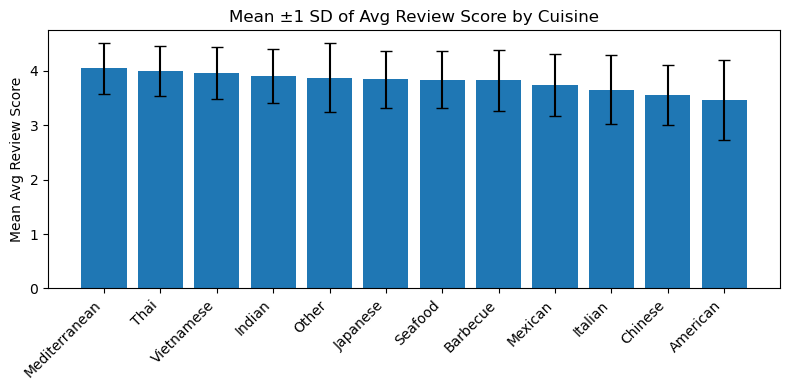

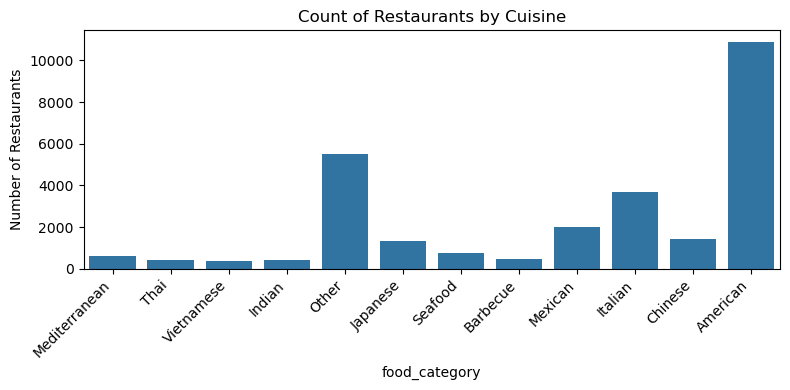

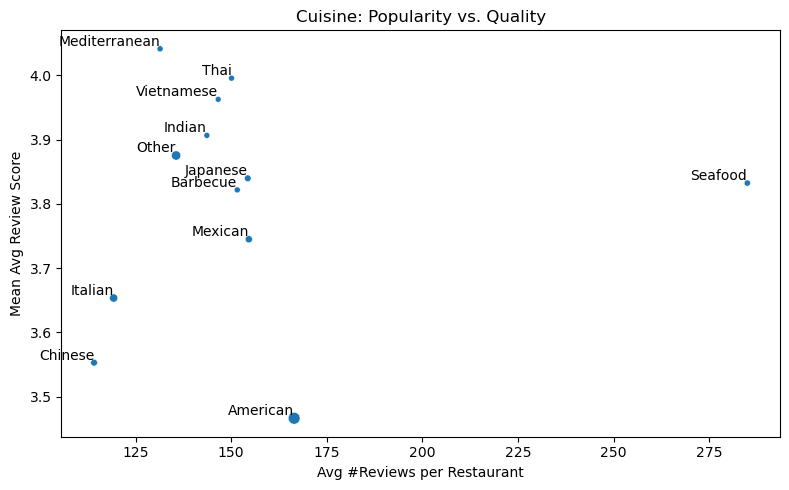

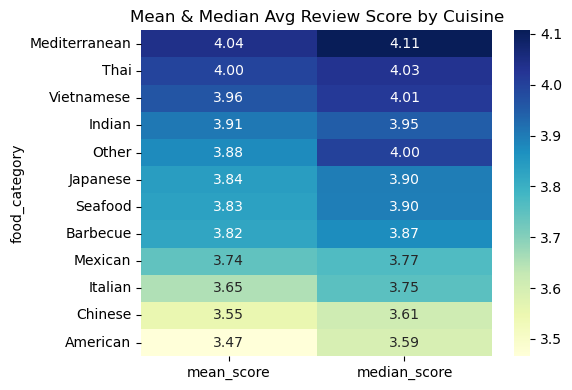

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Compute cuisine‐level summary stats
cuisine_stats = restaurants_df.groupby('food_category') \
    .agg(
        mean_score   = ('avg_review_score','mean'),
        median_score = ('avg_review_score','median'),
        std_score    = ('avg_review_score','std'),
        n_rest       = ('business_id','size'),
        avg_reviews  = ('review_count','mean')
    ) \
    .sort_values('mean_score', ascending=False) \
    .reset_index()

plt.figure(figsize=(8,4))
plt.bar(
    cuisine_stats['food_category'],
    cuisine_stats['mean_score'],
    yerr=cuisine_stats['std_score'],
    capsize=4
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Avg Review Score")
plt.title("Mean ±1 SD of Avg Review Score by Cuisine")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(
    data=cuisine_stats,
    x='food_category',
    y='n_rest'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Restaurants")
plt.title("Count of Restaurants by Cuisine")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=cuisine_stats,
    x='avg_reviews',
    y='mean_score',
    size='n_rest',
    legend=False,
    s=100
)
for _, row in cuisine_stats.iterrows():
    plt.text(row.avg_reviews, row.mean_score, row.food_category,
             horizontalalignment='right', verticalalignment='bottom')
plt.xlabel("Avg #Reviews per Restaurant")
plt.ylabel("Mean Avg Review Score")
plt.title("Cuisine: Popularity vs. Quality")
plt.tight_layout()
plt.show()

heat = cuisine_stats[['food_category','mean_score','median_score']].set_index('food_category')
plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Mean & Median Avg Review Score by Cuisine")
plt.tight_layout()
plt.show()
